# Introduction

Sometimes a subsystem is very helpful for encapsulating a complicated system. In Drake, a subsystem can be created via making a diagram, since diagram is also a system. In another word, if a diagram A contains another diagram B, then diagram B becomes a subsystem of diagram A. Thus a subsystem can be constructed in the same way as is shown in tutorial-1. 

## Example:

we want to create a subsystem, that contains a self-defined gain and an adder provided by Drake. Then we connect this subsystem with a integrator in a bigger diagram, which shall be simulated. The over all system can be expressed as:

$ y = \int{(u_0 + u_1)*2}dt$

1. We create a self-defined gain (see tutorial-4)

In [1]:
from pydrake.systems.framework import LeafSystem

class Gain(LeafSystem):
    def __init__(self, gain):
        LeafSystem.__init__(self)

        self.gain = gain

        self._in_port = self.DeclareVectorInputPort(name="in", size=1)
        self.DeclareVectorOutputPort(name="out", size=1, calc=self.CalcOutput)

    def CalcOutput(self, context, output):
        input = self._in_port.Eval(context)
        output.set_value(self.gain*input)

2. We make a factory class to construct the subsystem (diagram) which contains the gain and an adder

In [2]:
from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.primitives import Adder

class SubsystemFactory():
    def __init__(self) -> None:
        self.gain = Gain(2)
        self.adder = Adder(num_inputs=2, size=1)
        self.diagram = None

    def create(self):
        builder = DiagramBuilder()
        builder.AddSystem(self.adder)
        builder.AddSystem(self.gain)
        builder.Connect(self.adder.GetOutputPort("sum"), self.gain.GetInputPort("in"))
        builder.ExportInput(self.adder.GetInputPort("u0"))
        builder.ExportInput(self.adder.GetInputPort("u1"))
        builder.ExportOutput(self.gain.GetOutputPort("out"))
        self.diagram = builder.Build()
        return self.diagram

3. We Integrate this subsystem into a bigger diagram, we use a logger to log the data (tutorial-3)

In [4]:
from pydrake.systems.primitives import Integrator
from pydrake.systems.primitives import LogVectorOutput

builder = DiagramBuilder()

subsystemFactory = SubsystemFactory()
subsystem = subsystemFactory.create()
integrator = Integrator(1)

builder.AddSystem(subsystem)
builder.AddSystem(integrator)
builder.Connect(subsystem.get_output_port(0), integrator.GetInputPort("u0"))
builder.ExportInput(subsystem.get_input_port(0))
builder.ExportInput(subsystem.get_input_port(1))
builder.ExportOutput(integrator.GetOutputPort("y0"))

logger = LogVectorOutput(integrator.GetOutputPort("y0"), builder)
logger.set_name("logger")

diagram = builder.Build()

4. We provide input value and simulate the system

In [5]:
from pydrake.systems.analysis import Simulator

simulator = Simulator(diagram)
context = simulator.get_mutable_context()
diagram.get_input_port(0).FixValue(context, 1)
diagram.get_input_port(1).FixValue(context, 3)

simulator.AdvanceTo(1)

5. We extract logged data and check the results

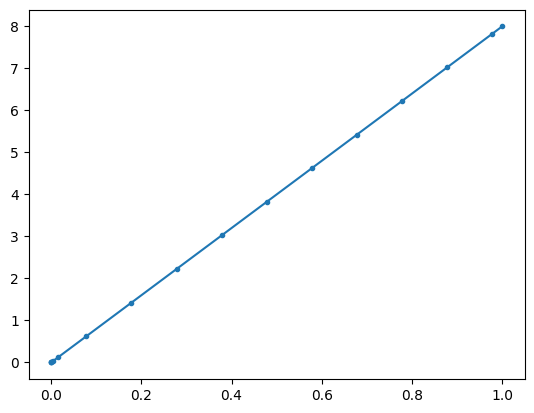

In [6]:
import matplotlib.pyplot as plt

log = logger.FindLog(simulator.get_context())
t = log.sample_times()

plt.figure()
# Plot theta.
plt.plot(t, log.data()[0,:],'.-')
plt.show()